In [2]:
.libPaths("/home/mahat/.conda/envs/r422/lib/R/library")
# .libPaths(c("/home/mahat/.conda/envs/r422/lib/R/library",
#             "/net/bmc-lab2/data/lab/scgroseq/group/software/R/x86_64-pc-linux-gnu-library/4.2"))
.libPaths()

[1] "/net/bmc-lab2/data/lab/sharp/mahat/conda/envs/r422/lib/R/library"

In [3]:
suppressMessages({
    library(tidyverse)
    library(dplyr)
    library(matrixStats)
    library(foreach)
    library(doParallel)
    library(plyranges)
    library(viridis)
    library(ggpointdensity)
    library(Matrix)
    library(data.table)
    library(Hmisc)
    library(gplots)
    library(rstatix)
    library(scattermore)
    library(igraph)
    library(ggraph)
    library(network)
    library(sna)
    library(statnet)
    library(rtracklayer)
    library(clusterProfiler)
    library(stringr)
    library(org.Mm.eg.db)
    library(circlize)
    library(gplots)
    library(RIdeogram)
    library(enrichplot)
    library(GOSemSim)
    library(dynamicTreeCut)
    library(WGCNA)
    library(ggrastr)
});
source("./scGRO_functions.r");

               Installed ReposVer Built  
ergm           "4.4.0"   "4.6.0"  "4.2.2"
network        "1.18.1"  "1.18.2" "4.2.2"
networkDynamic "0.11.3"  "0.11.4" "4.2.2"
sna            "2.7-1"   "2.7-2"  "4.2.2"
statnet.common "4.8.0"   "4.9.0"  "4.2.2"
tergm          "4.1.1"   "4.2.0"  "4.2.2"


Warning message:
“package ‘ggrastr’ was built under R version 4.2.3”


In [4]:
registerDoParallel(16);
options(
    repr.plot.width=6,
    repr.plot.height=6,
    jupyter.plot_mimetypes = "image/svg+xml",
    digits=5
);
theme_set(theme_classic() +
    theme(
        axis.title.x = element_text(color="black", size=14, face="bold"), 
        axis.title.y = element_text(color="black", size=14, face="bold"),
        axis.text = element_text(color="black", size=12, face="bold"),
        plot.title = element_text(face="bold", size=14, hjust = 0.5),
        axis.line = element_blank(),
        # axis.ticks = element_blank()
        panel.border = element_rect(colour = "grey", fill=NA, linewidth=1)
    )
);

In [5]:
# Get equation and r^2 as string
# https://groups.google.com/forum/#!topic/ggplot2/1TgH-kG5XMA

lm_eqn = function(x, y) {
    m = lm(y ~ x+0);
    eq = substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 2)))
    eq2 = substitute(italic(y) == a %.% italic(x)*","~~italic(r)^2~"="~r2, 
     list(a = format(unname(coef(m)[1]), digits = 2),
         r2 = format(summary(m)$r.squared, digits = 2)))

    as.character(as.expression(eq2));
}

In [6]:
# load genes with dREG status for expression filter
genesWithdREGstatus = readRDS("../data/groHMM_dREG_refinedGenes_mES_mm10.rds");
genesWithdREGstatus
# load groHMM-extended genes and enhancers
# features = read_bed("../data/groHMM_mES_BRsComb_LP-50_UTS10_features_customized_v2.bed");

# load features
features = read_bed("../data/groHMM_dREG_refinedFeatures_mES_mm10_OSNcustomEnhancers_SEs.bed");
# features = read_bed("../data/mES_BRsComb_dREGfiltered_features_customized_OSNenhancersPlusSEs_v1.bed");
# features = read_bed("../data/groHMM_mES_BRsComb_LP-50_UTS10_features_customized_OSNenhancersPlusSEs_v2.bed");
names(features) = features$name;
features$name=NULL;
features$score=NULL;
features

GRanges object with 23980 ranges and 2 metadata columns:
                  seqnames            ranges strand |            name      dREG
                     <Rle>         <IRanges>  <Rle> |     <character> <logical>
        GN-Lypla1     chr1   4807559-4857592      + |       GN-Lypla1      TRUE
         GN-Tcea1     chr1   4857693-4916049      + |        GN-Tcea1      TRUE
       GN-Atp6v1h     chr1   5082977-5170849      + |      GN-Atp6v1h      TRUE
         GN-Oprk1     chr1   5588449-5606134      + |        GN-Oprk1      TRUE
        GN-Rb1cc1     chr1   6214661-6287049      + |       GN-Rb1cc1      TRUE
              ...      ...               ...    ... .             ...       ...
  GN-LOC108168665     chrY 86943635-86944319      - | GN-LOC108168665     FALSE
  GN-LOC108168654     chrY 88804769-88805453      - | GN-LOC108168654     FALSE
       GN-Gm21996     chrY 89700320-89745550      - |      GN-Gm21996     FALSE
  GN-LOC108168534     chrY 90737350-90750205      - | GN-LOC108

GRanges object with 36559 ranges and 0 metadata columns:
                seqnames            ranges strand
                   <Rle>         <IRanges>  <Rle>
      GN-Lypla1     chr1   4807559-4857592      +
       GN-Tcea1     chr1   4857693-4916049      +
     GN-Atp6v1h     chr1   5082977-5170849      +
       GN-Oprk1     chr1   5588449-5606134      +
      GN-Rb1cc1     chr1   6214661-6287049      +
            ...      ...               ...    ...
  chrY-90724550     chrY 90724550-90727549      *
  chrY-90737450     chrY 90737450-90742449      *
  chrY-90742920     chrY 90742920-90745919      *
  chrY-90760850     chrY 90760850-90765849      *
  chrY-90774850     chrY 90774850-90777849      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

In [7]:
# genes shorter than 1500 are: 2931
# genes shorter than 1000 are: 2209
# genes shorter than  500 are:  484
# genes shorter than  200 are:  147

# short Gm### genes
shortGm = features %>%
    filter( substr(names, 0, 3) == "GN-" ) %>%
    filter( width > 200 ) %>%
    filter( width < 1000 & substr(names, 0, 5) == "GN-Gm" );
length(shortGm)
summary(width(shortGm))
names(shortGm)[1:5]

# define highly expressed "blacklist" genes to be
# removed from correlations
blacklist = grep( "GN-Rp[ls]" , names(features) );
blacklist = grep( "GN-Sn[oh]", names(features) ) %>%
    append(blacklist);

blacklist = names(features)[ blacklist ];
length(blacklist)
summary(width(features[ blacklist ]))
blacklist[c(1:5, 110:115)]

[1] 614

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    203     401     626     612     815     999 

[1] "GN-Gm8210"  "GN-Gm33795" "GN-Gm10561" "GN-Gm20257" "GN-Gm39669"

[1] 117

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    375    6785   10938   16845   15023  200344 

[1] "GN-Snhg6"   "GN-Snhg7os" "GN-Snhg11"  "GN-Snhg7"   "GN-Snhg17" 
 [6] "GN-Rps6kb2" "GN-Rps6ka4" "GN-Rpl10"   "GN-Rpl36a"  "GN-Rps6ka3"
[11] "GN-Rpl39"

In [8]:
# Specify feature length (half at the start and other half at the end)
# to be trimmed to eliminate the effect of paused Pol II at TSS and TES
trimEndLength =  1000;
# specify maximum gene length to be used for G-E correlation:
maxLength = 10000;

In [9]:
# filter genes
genes = features %>%
    filter( substr(names, 0, 3) == "GN-" ) %>%
# remove genes less than 200 nt (mostly Gm genes)
    filter( width >= 200 ) %>%
# filter genes with dREG peaks
    filter( names %in% names(genesWithdREGstatus[genesWithdREGstatus$dREG == T]) | 
           !names %in% names(genesWithdREGstatus) ) %>%
# filter highly expressed genes
    filter(!names %in% blacklist ) %>%
# filter Gm genes shorter than 1 kb
    filter(!names %in% names(shortGm) );

# trim 250 nt from either ends of genes that are longer than 1000
trimGenes = which( width(genes) >= 1000 );
genes[trimGenes] = genes[trimGenes] %>%
# truncate 500 bp in the front and 500 nt in the end of long genes
    anchor_center() %>%
    mutate( width = width - 500);

# trim additional 250 nt from either ends of genes that are now longer than 1000 (originally 1500)
trimGenes = which( width(genes) >= 1000 );
genes[trimGenes] = genes[trimGenes] %>%
# truncate 500 bp in the front and 500 nt in the end of long genes
    anchor_center() %>%
    mutate( width = width - 500);

# trim the long genes to 10 kb
longf = which( width(genes) >= 10000 );
genes[longf] = genes[longf] %>%
    resize( width = 10000, fix="start" );
length(genes)
# summary(width(genes %>% filter(width <1000)))
summary(width(genes))

[1] 15666

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    200   10000   10000    8738   10000   10000 

In [10]:
# # create 10kbp time-bins within each feature
# timebins1 = resize( genes,  width= 10000, fix="start" );

# # intersect with original features to trim excess
# # (some features are <30 kbp)
# timebins1 = pintersect( timebins1, genes );

In [11]:
scGRO = readRDS("../data/scGROv2p8_consolidated.rds");
counts = readRDS("../data/scGROv2p8_mapq3qc_max10kbp_filtered_counts.rds");
#counts = counts[,colSums(counts) >= 1000 ];
dim(counts)
allcells = colnames(counts);

[1] 36559  2635

In [12]:
table(substr(allcells, 0, 6));


Exp156 Exp160 Exp208 Exp211 Exp236 Exp246 Exp260 Exp263 Exp264 
   104    100    142    115    835     93    679    268    299 

In [13]:
# Merge experiment ID and cell barcode to create unique cell ID across experiments
scGRO = scGRO %>%
    filter( mapq >= 3 & countQC & umiQC & plateQC & cellQC & miRQC ) %>%
    subsetByOverlaps( genes ) %>%
    mutate( cellID = factor( paste( Exp, Plate, Cell, sep="-") ) ) %>%
    filter( cellID %in% allcells ) #%>%
    # select( cellID );

scGRO

GRanges object with 1074546 ranges and 12 metadata columns:
            seqnames            ranges strand |      mapq    PolPos      Exp
               <Rle>         <IRanges>  <Rle> | <integer> <integer> <factor>
        [1]     chr1   4808020-4808069      + |         3   4808069  Exp264a
        [2]     chr1   4808144-4808171      + |        42   4808171  Exp264a
        [3]     chr1   4808183-4808243      + |        40   4808243  Exp260b
        [4]     chr1   4808217-4808271      + |        23   4808271  Exp236 
        [5]     chr1   4808223-4808280      + |        42   4808280  Exp156 
        ...      ...               ...    ... .       ...       ...      ...
  [1074542]     chrY 90828680-90828724      - |        22  90828680  Exp236 
  [1074543]     chrY 90828694-90828728      - |        42  90828694  Exp260b
  [1074544]     chrY 90828695-90828735      - |        28  90828695  Exp236 
  [1074545]     chrY 90828695-90828737      - |         4  90828695  Exp236 
  [1074546]     

In [ ]:
counts = foreach(
    id = allcells,
    .combine="cbind2"
) %dopar% {
    reads = scGRO %>% filter(cellID == id);
    # count reads in each feature for this cellID
    counts1 = countOverlaps( genes, reads );

    counts = cbind(counts1) %>%
        Matrix(sparse=T);

    return( counts );
}
# columns = cells = cellIDs
colnames(counts) = allcells;
rownames(counts) = names(genes);
dim(counts)

[1] 15666  2635

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 179 rows containing non-finite values (`stat_bin()`).”


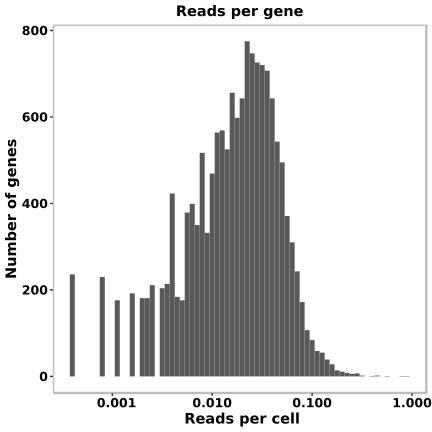

In [13]:
data.frame(
    x=rowMeans(counts>0)
) %>%
    ggplot( aes(x=x) ) +
    geom_histogram(binwidth=0.05) +
    scale_x_log10() +
    ggtitle("Reads per gene") +
    xlab("Reads per cell") +
    ylab("Number of genes");

In [14]:
# only retain features with counts in 0.1% or more cells
observed = counts[ rowMeans(counts>0) >= 0.001, ];
dim(observed)

# # only retain features with counts in 1% or more cells
# observed = counts[ rowMeans(counts>0) >= 0.01, ];
# dim(observed)

[1] 15021  2635

In [ ]:
# Niters = 100;
# Ncells = ncol(observed);
# Ngenes = nrow(observed);
# Nreads = colSums(observed);

# # sampling probability = read count / total reads in each cell
# bin1total = colSums(observed[, allcells]);
# pmatrix1 = t(t(observed[, allcells]) / bin1total);

# # average across cells
# pvector1 = rowMeans(pmatrix1);

## GxG Correlation & p-value from chi-square test:

In [17]:
# The matrix had to be converted to integer type for chi-square function written by chatGPT:
forceMatrixToInteger <- function(m){
    apply (m, c (1, 2), function (x) {
         (as.integer(x))
    })
}

In [18]:
# transforming the matrix to calculate corr, hmisc package reqires genes in columns and cells in rows

obsx = as.matrix(t(observed))
# obsx = as.matrix(t(observed[1:100, 1:50]))
# Binarize observed counts
# obsx = as.matrix(t(observed[1:100, 1:50]))
obsx[obsx > 1] = 1;

obsB = forceMatrixToInteger(obsx)
dim(obsB)

[1]  2635 15021

In [19]:
# Function to calculate chi-square p-value for a pair of genes
chi_square_test = function(gene1, gene2) {
  # Create contingency table
  table = table(gene1, gene2)
  
  # Perform chi-square test
  test = chisq.test(table, correct = FALSE) # 'correct = FALSE' to avoid Yates' correction
  return(test$p.value)
}

In [20]:
# ++++++++++++++++++++++++++++
# flattenCorrMatrix
# ++++++++++++++++++++++++++++
# cormat : matrix of the correlation coefficients
# pmat : matrix of the correlation p-values
flattenCorrMatrix = function(cormat, pmat) {
  ut = upper.tri(cormat)
  data.frame(
    geneA = rownames(cormat)[row(cormat)[ut]],
    geneB = rownames(cormat)[col(cormat)[ut]],
    corr = (cormat)[ut],
    pVal = pmat[ut]
    )
}

#### Pearson correlation on binarized data:

In [21]:
# set.seed(123)
# obsB <- matrix(sample(0:1, 100, replace = TRUE), nrow = 50, ncol = 100);
# colnames(obsB) = paste0("GN-", c(1:100));
# rownames(obsB) = paste0("Exp-C-", c(1:50));
# obsB

In [22]:
# Apply the function to all pairs of genes
suppressWarnings({
    chSq_pVal = outer(1:ncol(obsB), 1:ncol(obsB), Vectorize(function(i, j) chi_square_test(obsB[,i], obsB[,j])))
                })
# colnames(p_values) = colnames(data)
# rownames(p_values) = colnames(data);
dim(chSq_pVal)
chSq_pVal[1:5,1:5]                                           

[1] 15021 15021

0.000000,0.0636207,0.0100294,0.99215,0.5096899
0.063621,0.0000000,0.0001283,0.91513,0.1357836
0.010029,0.0001283,0.0000000,0.37651,0.0079725
0.992149,0.9151302,0.3765105,0.00000,0.5419040
0.509690,0.1357836,0.0079725,0.54190,0.0000000


In [23]:
# use hmisc package to calculate correlation and p-value:
corrP = rcorr(obsB, type = "pearson")
dim(corrP$r)
corrP$r[1:5,1:5]
dim(corrP$P)
corrP$P[1:5,1:5]

[1] 15021 15021

,GN-Lypla1,GN-Tcea1,GN-Atp6v1h,GN-Oprk1,GN-Rb1cc1
GN-Lypla1,1.0000000,0.0361338,0.050160,0.0001917,0.012844
GN-Tcea1,0.0361338,1.0000000,0.074606,0.0020761,0.029059
GN-Atp6v1h,0.0501598,0.0746060,1.000000,-0.0172278,0.051687
GN-Oprk1,0.0001917,0.0020761,-0.017228,1.0000000,-0.011882
GN-Rb1cc1,0.0128442,0.0290593,0.051687,-0.0118821,1.000000


[1] 15021 15021

,GN-Lypla1,GN-Tcea1,GN-Atp6v1h,GN-Oprk1,GN-Rb1cc1
GN-Lypla1,NA,0.06365990,0.01001782,0.99215,0.5098733
GN-Tcea1,0.063660,NA,0.00012648,0.91517,0.1358867
GN-Atp6v1h,0.010018,0.00012648,NA,0.37670,0.0079604
GN-Oprk1,0.992152,0.91517022,0.37670157,NA,0.5420814
GN-Rb1cc1,0.509873,0.13588667,0.00796036,0.54208,NA


In [25]:
corrPflat = flattenCorrMatrix( corrP$r, chSq_pVal ) %>%
    mutate( pAdj = p.adjust(pVal, method = "bonferroni") ) %>%
    mutate( corrRank = rank(corr) ) %>%
    mutate( pValRank = rank(pVal) );
dim(corrPflat)
head(corrPflat)
fwrite(corrPflat, file="../data/scGROv2p8_GxG_max10kbp_binary_correlation_chiSquare.csv.gz")

[1] 112807710         7

,geneA,geneB,corr,pVal,pAdj,corrRank,pValRank
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GN-Lypla1,GN-Tcea1,0.0361338,0.0636207,1,87179666,25647688
2,GN-Lypla1,GN-Atp6v1h,0.0501598,0.0100294,1,98620214,14187782
3,GN-Tcea1,GN-Atp6v1h,0.0746060,0.0001283,1,108819435,3988280
4,GN-Lypla1,GN-Oprk1,0.0001917,0.9921487,1,46209450,112480950
5,GN-Tcea1,GN-Oprk1,0.0020761,0.9151302,1,47881306,108985474
6,GN-Atp6v1h,GN-Oprk1,-0.0172278,0.3765105,1,4549845,52060232
